In [1]:
from skimage import measure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import os
from PIL import Image
from os import listdir
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
df = ""
PATH = "./Dataset/"

for filename in os.listdir(PATH):
    if filename.startswith("P") and filename.endswith(".pkl"): 
        dfTemp = pd.read_pickle(PATH + filename)
        if (type(df) is str):
            df = dfTemp
        else:
            df = df.append(dfTemp)
    else:
        continue

df = df.reset_index()

## Removing erroneous data and detecting blobs

In [3]:
input_array = []
aray2 = []
neural_ip = []
x_curr = []
indx = []
y_curr = []
x_actual_down = []
y_actual_down = []
x_centroid = []
y_centroid = []
participant = []

SCREEN_WIDTH = 1079
SCREEN_HEIGHT = 1919
CAPIMG_WIDTH = 15
CAPIMG_HEIGHT = 27
THRESHOLD = 10

In [4]:
%%time
for index,row in df.iterrows():
    x = row['array']
    x = np.fromstring(x[1:-1], sep=",")
    x[x < 0] = 0
    x[x > 255] = 255
    x = np.asarray(x)
    test_image = np.reshape(x,(27,15))
    test_image = test_image.astype(np.uint8)
    
    # Remove noise by creating a threshold image (i.e. all cell values less than 10)
    ret, threshold = cv2.threshold (test_image, THRESHOLD, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # If there are no contours, return null coordinates.
    if (contours ==[]):
        continue
    else:
        # Determines maximum area contour.
        c = max(contours, key = cv2.contourArea)
        
        if c.size == 2 :
            continue
        
        # Determine the most extreme points along the contour
        extLeft = tuple(c[c[:,:, 0].argmin()][0])
        extRight = tuple (c[c[:,:, 0].argmax()][0])
        extTop = tuple(c[c[:,:, 1].argmin()][0])
        extBot = tuple(c[c[:,:, 1].argmax()][0])
    
        cen_x = (extLeft[0] + extRight[0]) / 2
        cen_y = (extTop[1] + extBot[1]) / 2
        
        x_ch = int((SCREEN_WIDTH / CAPIMG_WIDTH) * cen_x)
        y_ch = int((SCREEN_HEIGHT / CAPIMG_HEIGHT) * cen_y)

        alist = [extLeft, extRight, extTop, extBot]
        temp = tuple(map(sorted, zip(*alist)))
        min_x, max_x, min_y, max_y = temp[0][0], temp[0][-1], temp[1][0], temp[1][-1]

        extreme_left = (min_x,min_y)
        extreme_right = (max_x,max_y)
        
        rec_pts = [extreme_left,extreme_right]
    if (rec_pts[0][0] == 0):
        row_strt = rec_pts[0][0]
    else:
        row_strt = rec_pts[0][0] - 1
    if (rec_pts[1][0] == 14 ):
        row_end = rec_pts[1][0]
    elif (rec_pts[1][0] == 13):
        row_end = rec_pts[1][0] + 1
    else:
        row_end = rec_pts[1][0] + 2
    if (rec_pts[0][1] == 0):
        col_strt = rec_pts[0][1]
    else:
        col_strt = rec_pts[0][1] - 1
    if (rec_pts[1][1] == 26 ):
        col_end = rec_pts[1][1]
    elif (rec_pts[1][1] == 25):
        col_end = rec_pts[1][1] + 1
    else:
        col_end = rec_pts[1][1]+ 2            

    mask = np.zeros((27,15), dtype="uint8")
    for i in range(col_strt,col_end+1):
        for j in range(row_strt,row_end+1):
            mask[i][j] = test_image[i][j]
    flat_mat = mask.flatten()
    
    # Remove errorneous data if distance between centroid of capacitive image and Android pos is > 300.
    if ((y_ch-row.y_curr) > 300):
        continue
    elif ((x_ch-row.x_curr) > 300):
        continue
    
    neural_ip.append(flat_mat)
    x_curr = np.append(x_curr,row['x_curr'])
    x_actual_down = np.append(x_actual_down,row['x_actual_down'])
    indx = np.append(indx,index)
    y_curr = np.append(y_curr,row['y_curr'])
    y_actual_down = np.append(y_actual_down,row['y_actual_down'])
    x_centroid = np.append(x_centroid,x_ch)
    y_centroid = np.append(y_centroid,y_ch)
    participant = np.append(participant, row['Participant_id'])
    
    # Show processing progress
    if (index % 1000 == 0):
        print("\r", "Progress: " + str(index) + " / " + str(len(df)) + " (" + "{:2.2f}".format(index / len(df) * 100) + "%)", end="")
    
aray2 = neural_ip.copy()
d = {'indx' :indx, 'x_curr': x_curr, 'y_curr': y_curr ,'x_actual':x_actual_down,'y_actual':y_actual_down, 'aray2' : aray2,'x_centroid':x_centroid,'y_centroid':y_centroid, 'participant': participant}
df1 = pd.DataFrame(data=d)

#final preprocessed data for each participant stired in Processed folder
df1.to_pickle('./Processed/preprocessed_data.pkl')

 Progress: 7000 / 392292 (1.78%)

## Reading Data Set (for Visualizations)
Visualising cross hair mid point and mobile returned touch point.

In [5]:
df = pd.read_pickle("./Processed/preprocessed_data.pkl")
print(df.shape)

(371071, 9)


In [6]:
df.head()

,indx,x_curr,y_curr,x_actual,y_actual,aray2,x_centroid,y_centroid,participant
0,0.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,533.0,P2
1,1.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,497.0,P2
2,2.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,497.0,P2
3,3.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,461.0,P2
4,4.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,604.0,P2


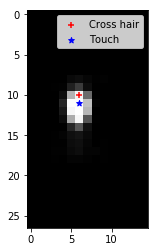

In [7]:
# Frame to visualize
idx_frame = 914
frame = df.iloc[idx_frame]

a = frame.aray2.reshape(27,15)  

x_ch = int((CAPIMG_WIDTH / SCREEN_WIDTH)*frame.x_curr)
y_ch = int((CAPIMG_HEIGHT / SCREEN_HEIGHT)*frame.y_curr)
x_act = int((CAPIMG_WIDTH / SCREEN_WIDTH)*frame.x_actual)
y_act = int((CAPIMG_HEIGHT / SCREEN_HEIGHT)*frame.y_actual)
fig = plt.figure()
ax = plt.subplot()
ax.imshow(a, interpolation = 'nearest', cmap = 'Greys_r')
plt.scatter(x_ch, y_ch, c='red', marker='+')
plt.scatter(x_act, y_act, c='blue', marker='*')
plt.legend(["Cross hair", "Touch"])
plt.savefig("offset_demo.pdf", bbox_inches="tight")

In [8]:
df.head()

,indx,x_curr,y_curr,x_actual,y_actual,aray2,x_centroid,y_centroid,participant
0,0.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,533.0,P2
1,1.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,497.0,P2
2,2.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,497.0,P2
3,3.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,461.0,P2
4,4.0,282.0,517.0,306.0,518.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",251.0,604.0,P2


In [9]:
df[df.participant.isin(("P2", "P3", "P4", "P5", "P6", "P8", "P9", "P10", "P11"))].to_pickle("train_set.pkl")
df[df.participant.isin(("P13", "P14", "P17"))].to_pickle("test_set.pkl")